In [8]:
%matplotlib inline

import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pprint
from pandas.plotting import register_matplotlib_converters
from collections import defaultdict
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

from qiskit.finance.data_providers import *
from qiskit.finance import QiskitFinanceError

from docplex.mp.model import Model

from qiskit.aqua.components.optimizers import COBYLA, SLSQP
register_matplotlib_converters()

# imported before setting global log level, since optim_wrapper sets log level
import grovers_search as grovers
import optim_wrapper as optimization

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
# setup aqua logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.ERROR)  # choose INFO, DEBUG to see the log

In [9]:
# Quantum Aggregator Wrapper
def aggregator(algorithm, dict_details):
    if algorithm == 'grovers':
        result = grovers.grovers_search(dict_details)
    if algorithm == 'optimizer':
        result = optimization.optimize_portfolio(dict_details)
    return result

In [10]:
def dates_gen(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

# example
s=datetime.datetime(2017, 1, 1)
e=datetime.datetime(2017, 6, 30)
d=relativedelta(months=1)

for date in dates_gen(s, e, d):
    print(date)

2017-01-01 00:00:00
2017-02-01 00:00:00
2017-03-01 00:00:00
2017-04-01 00:00:00
2017-05-01 00:00:00
2017-06-01 00:00:00


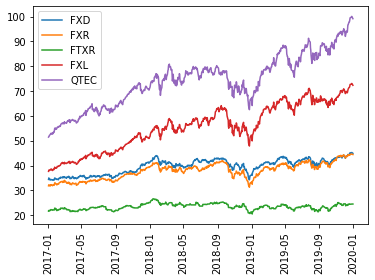

In [11]:
# just some plotting, to visualize data. NB: be sure that every time series is
# defined over the entire observation period
try:
    data = YahooDataProvider(
                 tickers = ['FXD', 'FXR', 'FTXR', 'FXL', 'QTEC'], # IFV ETF 
                 start=datetime.datetime(2017, 1, 1),
                 end=datetime.datetime(2019, 12, 31))
    data.run()
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex:
    data = None
    print(ex)

In [12]:
solvers = ['vqe', 'classic']

n = 5            # number of assets
q = 0.5          # risk factor
budget = n // 2  # budget
penalty = 2*n    # scaling of penalty term

optim_dict = {
  #"docplex_mod": mdl,
  "quantum_instance": 'qasm_simulator',
  "shots": 1024,
  "print": False, 
  #"solver": solver_name, (to be added)
  "optimizer": SLSQP,
  "maxiter":1000,
  "depth":1,
  "alpha":0.35,
  "penalty": 2*n
}

In [13]:
optim_start_date=datetime.datetime(2017, 10, 1)
optim_end_date=datetime.datetime(2017, 12, 31)
optim_step_delta=relativedelta(months=1)
past_delta=relativedelta(months=6)  #used to compute mu and sigma at each optimization step

optim_dates = list(dates_gen(optim_start_date, optim_end_date, optim_step_delta)) #cast to list just for using tqdm

overall_results = {s : {} for s in solvers}

for optim_date in tqdm(optim_dates):
    computation_start = optim_date-past_delta
    computation_end = optim_date
    
    # Loads data, thus enabling get_similarity_matrix and
    # get_covariance_matrix methods in the base class
    data = YahooDataProvider(
                 tickers = ['FXD', 'FXR', 'FTXR', 'FXL', 'QTEC'], # IFV ETF 
                 start=computation_start,
                 end=computation_end)
    data.run()
    mu = data.get_period_return_mean_vector()
    sigma = data.get_period_return_covariance_matrix()
    
    # create docplex model
    mdl = Model('portfolio_optimization')
    x = mdl.binary_var_list('x{}'.format(i) for i in range(n))
    objective = mdl.sum([mu[i]*x[i] for i in range(n)])
    objective -= q * mdl.sum([sigma[i,j]*x[i]*x[j] for i in range(n) for j in range(n)])
    mdl.maximize(objective)
    mdl.add_constraint(mdl.sum(x[i] for i in range(n)) == budget)
    
    for s in solvers:
        optim_dict['docplex_mod'] = mdl
        optim_dict['solver'] = s
        results = aggregator('optimizer', optim_dict)
        
        comp_time = results['computational_time']
        res = results['result']
        ret = sum([mu[i]*res.x[i] for i in range(n)])
        vol = q * sum([sigma[i,j]*res.x[i]*res.x[j] for i in range(n) for j in range(n)])
        value = ret-vol 
        assert math.isclose(value, res.fval, abs_tol=1e-10)    
        overall_results[s][optim_date] = (value, ret, vol, comp_time)
        
        #print(computation_start, computation_end)
        #print(f"solver: {s}, optim date: {optim_date}, success: {res.status}")
        #print(f"objective function value: {value}, return term: {ret}, volatility term: {vol}, computation time {comp_time}")
        #print()

100%|██████████| 3/3 [00:25<00:00,  8.58s/it]


In [75]:
pprint.pprint(overall_results)

{'classic': {datetime.datetime(2017, 10, 1, 0, 0): (0.0020029657309423533,
                                                    0.0021755467938289873,
                                                    0.0001725810628866342,
                                                    0.016260897999927693),
             datetime.datetime(2017, 11, 1, 0, 0): (0.002616354157469933,
                                                    0.0027774754904900016,
                                                    0.00016112133302006873,
                                                    0.024679903999640374),
             datetime.datetime(2017, 12, 1, 0, 0): (0.002174429311745293,
                                                    0.002265841106095353,
                                                    9.141179435005993e-05,
                                                    0.01656923700011248)},
 'vqe': {datetime.datetime(2017, 10, 1, 0, 0): (0.0020029657309423533,
                               

In [14]:
(np.array(overall_results[solvers[0]][optim_start_date][0])-np.array(np.array(overall_results[solvers[1]][optim_start_date][0])))/np.array(overall_results[solvers[1]][optim_start_date][0])

0.0

In [15]:
(np.array(overall_results[solvers[0]][optim_start_date][3])-np.array(np.array(overall_results[solvers[1]][optim_start_date][3])))/np.array(overall_results[solvers[1]][optim_start_date][3])

26.930376414636047